In [165]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import spacy
from collections import Counter
from pprint import pprint

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning) 

random_seed = 0
np.random.seed(random_seed)

In [2]:
def get_num_lines(path):
    with open(path) as f:
        for i, _ in enumerate(f):
            pass
    return i+1

---
---

## Review

In [3]:
file_path = os.path.join("data", "yelp_dataset", "yelp_academic_dataset_review.json")
data_review = pd.read_json(file_path, lines=True, nrows=1000000)  # 6990280 x 9
display(data_review.head(2), data_review.shape)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18


(1000000, 9)

In [4]:
(get_num_lines(file_path), data_review.shape[1])

(6990280, 9)

### Regardons plus en détails les variables du jeu de données

#### Les variables qualitatives

In [5]:
data_review.describe(exclude=['number','datetime']).T

,count,unique,top,freq
review_id,1000000,1000000,KU_O5udG6zpxOg-VcAEodg,1
user_id,1000000,542003,_BcWyKQL16ndpBdggh2kNA,483
business_id,1000000,27095,GBTPC53ZrG1ZBY3DT8Mbcw,4661
text,1000000,998357,I have eaten at just about every decent Indian...,5


#### Les variables quantitatives

In [6]:
data_review.describe(datetime_is_numeric=True).T

,count,mean,min,25%,50%,75%,max,std
stars,1000000.0,3.783959,1.0,3.0,4.0,5.0,5.0,1.440197
useful,1000000.0,1.106594,0.0,0.0,0.0,1.0,539.0,2.848906
funny,1000000.0,0.307812,0.0,0.0,0.0,0.0,284.0,1.428185
cool,1000000.0,0.457129,0.0,0.0,0.0,0.0,172.0,1.799114
date,1000000,2016-07-13 10:09:02.464016128,2005-03-01 17:47:15,2014-08-07 16:29:16.500000,2016-10-11 16:02:42,2018-09-01 01:26:22.249999872,2022-01-19 19:47:59,NaN


### Affichons la répartition des notes de review

In [7]:
def plot_bars(data_, title, labels_modulo=1, labels_rotation=90, show_values=True, show_percent=False, x_label=None, y_label=None, **args):
    
    if show_percent:
        total = data_.values.sum()
        data_ = round(data_/total*100.0,2)

    fig = plt.figure(figsize=(15, 4))
    
    ax = sns.barplot(data=data_, **args)
    
    if show_values:
        ax.bar_label(ax.containers[0])
        
    new_ticks = [i.get_text() for i in ax.get_xticklabels()]
    plt.xticks(range(0, len(new_ticks), labels_modulo), new_ticks[::labels_modulo], rotation=labels_rotation)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title(title)
    plt.show()

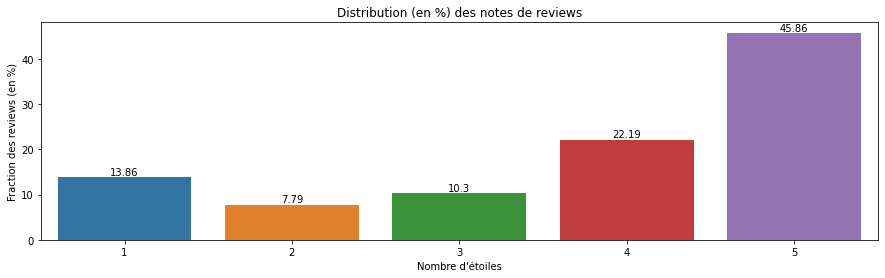

In [8]:
select = pd.DataFrame(data_review.stars.value_counts()).reset_index()
select.sort_values(by='index', inplace=True)
select.set_index('index', inplace=True)

plot_bars(select.T, "Distribution (en %) des notes de reviews", y_label="Fraction des reviews (en %)", x_label="Nombre d'étoiles", labels_rotation=0, show_percent=True)

## Préparation d'un jeu de données des "mauvais" commentaires

### Binarisation des reviews

In [9]:
data_review['is_low'] = data_review.stars < 3 # TRUE with 1,2 stars and FALSE with 3,4,5 stars
display(data_review.head(2), data_review.shape)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,is_low
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,False
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18,False


(1000000, 10)

### Sélection au hasard des reviews dont les notes sont 1 ou 2

In [10]:
sample_size = 10000

In [11]:
# Select samples with the original dataset stars' ratio
data_bad_reviews = data_review[data_review.is_low == True].sample(sample_size, random_state=random_seed)[['stars', 'text']].reset_index(drop=True)
display(data_bad_reviews.head(2), data_bad_reviews.shape)

,stars,text
0,1,They do not care about customers. My online o...
1,1,Food is gross and service is about as bad. Tri...


(10000, 2)

### Affichage de la distribution des scores dans le nouveau dataset

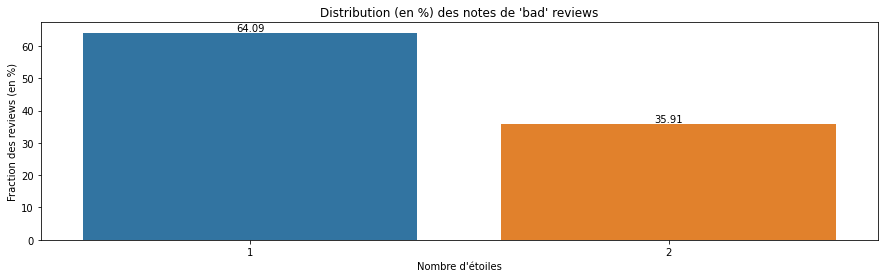

In [12]:
select = pd.DataFrame(data_bad_reviews.stars.value_counts()).reset_index()
select.sort_values(by='index', inplace=True)
select.set_index('index', inplace=True)

plot_bars(select.T, "Distribution (en %) des notes de 'bad' reviews", y_label="Fraction des reviews (en %)", x_label="Nombre d'étoiles", labels_rotation=0, show_percent=True)

### Sauvegarde du nouveau dataset contenant les mauvaises reviews

In [13]:
data_bad_reviews.to_csv("data/export_bad_reviews.csv", index=False)

# Préparation des données textuelles

In [90]:
data_bad_reviews = pd.read_csv("data/export_bad_reviews.csv", nrows=1000)
display(data_bad_reviews.head(2), data_bad_reviews.shape)

,stars,text
0,1,They do not care about customers. My online o...
1,1,Food is gross and service is about as bad. Tri...


(1000, 2)

## Visualisation du jeu de données avant nettoyage

In [91]:
from wordcloud import WordCloud

In [92]:
def plot_wordcloud(text):
    # Create the wordcloud object
    wordcloud = WordCloud(width=800, height=800, margin=2, collocations=False, random_state=random_seed).generate(text)

    # Display the generated image:
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.show()

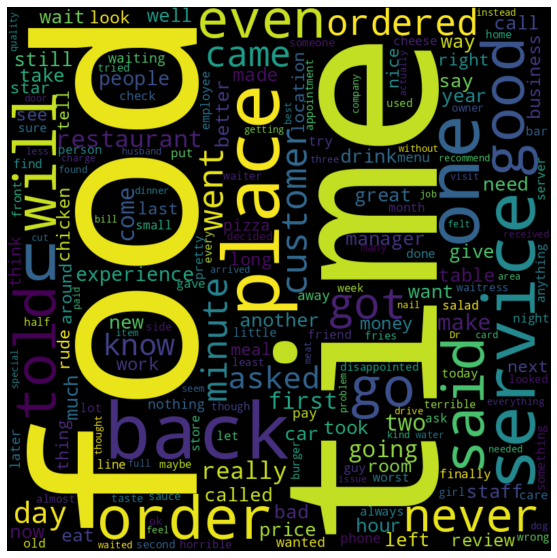

In [93]:
plot_wordcloud(" ".join(data_bad_reviews.text))

## Nettoyage du jeu de données

In [94]:
# !python -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm')

In [195]:
def clean_dataset( data, drop_lemmas=[] ):

    all_lemmas = []
    all_corpus = []

    for index, row in data.iterrows():
    
        # suppression des majuscules
        text = row['text'].lower()

        # suppression des espaces au début et à la fin des textes
        text_clean = text.strip()

        # tokenisation
        doc = nlp(text_clean)
        # spacy.displacy.render(doc, style='dep',jupyter=True)

        # suppression des stopwords, de la ponctuation, des espaces et des adverbes
        tokens = [token for token in doc if not token.is_stop and not token.is_punct and not token.is_space and not token.is_digit and token.pos_ not in ['ADV']]

        # lemmatization
        lemmas = [token.lemma_ for token in tokens if token.lemma_ not in [*drop_lemmas]]

        # on les ajoute à la liste globale des mots
        all_lemmas.extend(lemmas)

        # on conserve les lemmas de chaque document pour les TF-IDF (on pourrait aussi ajouter une colonne au jeu de données)
        all_corpus.append(" ".join(lemmas))
        
    return all_lemmas, all_corpus

In [196]:
all_lemmas, all_corpus = clean_dataset(data_bad_reviews)

## Visualisation (wordcloud) des lemmes retenus

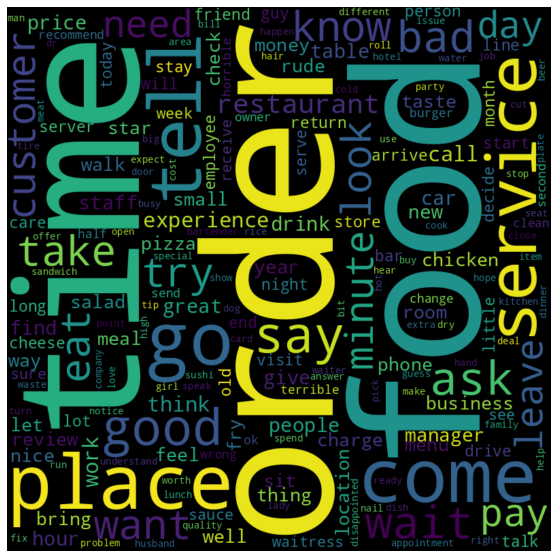

In [197]:
plot_wordcloud(" ".join(all_lemmas))

## Suppression des mots les plus fréquents

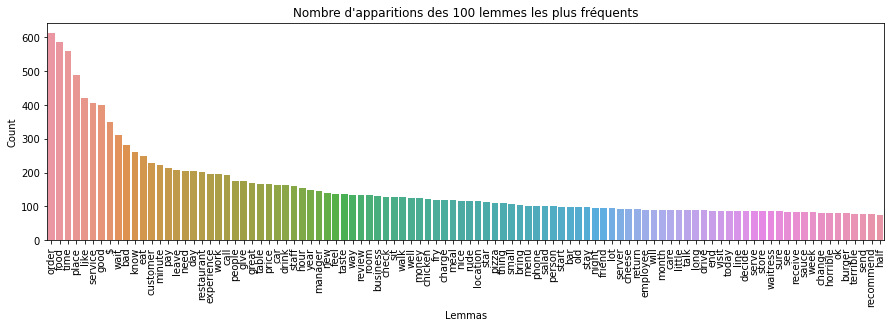

In [198]:
select = pd.DataFrame(common_lemmas[:200], columns=['lemmas','count'])
plot_bars(select, title="Nombre d'apparitions des 200 lemmes les plus fréquents", x='lemmas', y='count', show_values=False, y_label="Count", x_label="Lemmas")

In [199]:
lemmas_freq = Counter(all_lemmas)
common_lemmas = lemmas_freq.most_common(100)
print (common_lemmas)

[('order', 613), ('food', 587), ('time', 559), ('place', 490), ('come', 485), ('go', 478), ('tell', 455), ('like', 422), ('service', 407), ('good', 400), ('say', 398), ('$', 351), ('get', 349), ('ask', 335), ('wait', 312), ('bad', 281), ('know', 261), ('take', 258), ('want', 250), ('eat', 248), ('look', 245), ('try', 236), ('customer', 228), ('minute', 222), ('pay', 213), ('leave', 207), ('need', 204), ('day', 204), ('restaurant', 203), ('experience', 195), ('work', 195), ('think', 195), ('call', 193), ('people', 174), ('give', 174), ('great', 168), ('table', 166), ('price', 166), ('car', 164), ('drink', 162), ('find', 160), ('staff', 159), ('hour', 155), ('year', 148), ('manager', 145), ('new', 141), ('feel', 138), ('taste', 136), ('way', 134), ('review', 133), ('room', 133), ('business', 131), ('check', 129), ('sit', 129), ('walk', 129), ('well', 124), ('money', 124), ('chicken', 121), ('fry', 120), ('charge', 119), ('meal', 119), ('nice', 117), ('rude', 117), ('location', 115), ('st

>#### ⚠️ A REFAIRE si on reste sur le drop_lemmas avec le top 100
> On pourrait supprimer les 13 ou 16 premiers lemmes, puisque c'est à cet endroit que l'on voit une inflection, mais ça reste très subjectif.
> Par ailleurs il y a beaucoup de mots qui concernent directement le sujet, aussi est-il préferable de ne retirer que le top-lemmas qui ne sont pas liés au sujet d'une façon ou d'une autre (et qui donc n'apporte aucune information particulière)...

In [220]:
drop_lemmas = [x[0] for x in lemmas_freq.most_common(100)]
#drop_lemmas.extend(['come', 'go', 'tell', 'say', 'get', 'ask', 'want', 'try', 'look', 'take', 'find', 'let', 'guy', 'arrive', 'think'])

In [221]:
all_lemmas, all_corpus = clean_dataset(data_bad_reviews, drop_lemmas)

## Visualisation (wordcloud) des lemmes retenus

/home/valkea/Dev/OpenClassrooms/Projets_AI/P6/venvP6/lib/python3.8/site-packages/wordcloud/wordcloud.py:512: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/home/valkea/Dev/OpenClassrooms/Projets_AI/P6/venvP6/lib/python3.8/site-packages/wordcloud/wordcloud.py:512: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/home/valkea/Dev/OpenClassrooms/Projets_AI/P6/venvP6/lib/python3.8/site-packages/wordcloud/wordcloud.py:492: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
/home/valkea/Dev/OpenClassrooms/Projets_AI/P6/venvP6/lib/python3.8/site-packages/wordcloud/wordcloud.py:512: DeprecationWarning: ROTATE_90 is depre

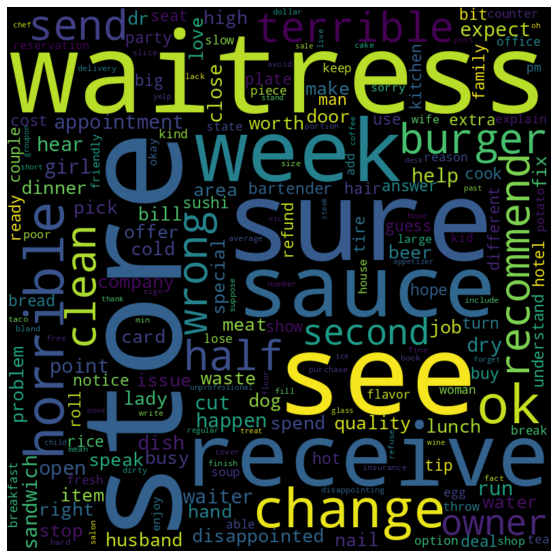

/home/valkea/Dev/OpenClassrooms/Projets_AI/P6/venvP6/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/valkea/Dev/OpenClassrooms/Projets_AI/P6/venvP6/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/valkea/Dev/OpenClassrooms/Projets_AI/P6/venvP6/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/valkea/Dev/OpenClassrooms/Projets_AI/P6/venvP6/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative us

In [222]:
plot_wordcloud(" ".join(all_lemmas))

In [203]:
lemmas_freq2 = Counter(all_lemmas)
common_lemmas2 = lemmas_freq2.most_common(100)
print (common_lemmas2)

[('store', 86), ('waitress', 85), ('sure', 85), ('see', 84), ('receive', 83), ('sauce', 82), ('week', 82), ('change', 81), ('horrible', 80), ('ok', 79), ('burger', 79), ('terrible', 78), ('send', 77), ('recommend', 77), ('half', 76), ('wrong', 76), ('clean', 76), ('owner', 76), ('second', 75), ('appointment', 75), ('cut', 75), ('waiter', 74), ('girl', 74), ('dry', 74), ('help', 73), ('close', 73), ('sandwich', 72), ('open', 72), ('expect', 71), ('run', 71), ('dish', 70), ('happen', 70), ('point', 69), ('hear', 69), ('disappointed', 68), ('dinner', 68), ('issue', 68), ('item', 67), ('make', 67), ('love', 67), ('bill', 67), ('quality', 66), ('company', 66), ('door', 66), ('speak', 66), ('offer', 65), ('hand', 65), ('water', 65), ('card', 65), ('dog', 65), ('fix', 64), ('area', 63), ('stop', 62), ('job', 62), ('husband', 61), ('waste', 61), ('lady', 61), ('special', 61), ('pick', 61), ('problem', 60), ('right', 60), ('meat', 59), ('cold', 59), ('spend', 59), ('nail', 59), ('lunch', 58), (

## Encodage du texte avec TF-IDF 

> #### ⚠️ NOTE:
> - all_corpus --> data_words[:1][0] ??
> - all_lemmas --> data_lemmatized

In [104]:
" | ".join(all_lemmas[:150])

'care | customer | online | order | chow | mein | lo | mein | not | budge | pay | order | accept | chow | mein | return | food | gross | service | bad | like | time | eat | low | quality | food | average | customer | service | good | food | smoke | wing | texture | like | cook | reheat | bad | breakfast | n | large | group | screw | breakfast | typical | problem | server | table | mixed | man | woman | old | gal | waitress | cater | man | n | gal | grow | moss | time | refill | coffee | n | wait | matter | fact | time | request | little | snippy | will | group | husband | call | request | basic | service | cleaning | problem | hvac | sell | home | agreement | buyer | inspection | hvac | quote | deep | cleaning | system | dirty | sell | home | interested | extra | service | need | restore | year | old | system | end | pay | service | cleaning | different | company | understand | price | dollar | service | include | filter | basic | cleaning | company | offer | research | contact | disap

In [105]:
import gensim.corpora as corpora

In [140]:
# Create Dictionary
id2word = corpora.Dictionary([all_lemmas])

In [142]:
# Create Corpus
texts = [all_lemmas]

In [143]:
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [160]:
# View
print(corpus[0][:150])

[(0, 351), (1, 1), (2, 14), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 2), (29, 1), (30, 1), (31, 2), (32, 1), (33, 1), (34, 4), (35, 4), (36, 1), (37, 1), (38, 18), (39, 5), (40, 5), (41, 2), (42, 1), (43, 2), (44, 1), (45, 1), (46, 1), (47, 2), (48, 1), (49, 2), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 2), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 2), (68, 2), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 2), (76, 2), (77, 3), (78, 1), (79, 1), (80, 3), (81, 1), (82, 1), (83, 2), (84, 2), (85, 1), (86, 2), (87, 1), (88, 1), (89, 1), (90, 2), (91, 1), (92, 1), (93, 2), (94, 1), (95, 6), (96, 1), (97, 2), (98, 2), (99, 1), (100, 1), (101, 3), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1), (110,

### LDA

In [153]:
from gensim.models import LdaMulticore

In [175]:
# Build LDA model
lda_model = LdaMulticore(
    corpus=corpus,
    id2word=id2word,
    num_topics=5, 
    random_state=100,
    chunksize=100,
    passes=10,
    per_word_topics=True
)

In [176]:
pprint(lda_model.print_topics(), width=200)

[(0, '0.000*"order" + 0.000*"food" + 0.000*"place" + 0.000*"time" + 0.000*"good" + 0.000*"service" + 0.000*"like" + 0.000*"bad" + 0.000*"wait" + 0.000*"experience"'),
 (1, '0.012*"order" + 0.012*"food" + 0.011*"time" + 0.010*"place" + 0.008*"like" + 0.008*"service" + 0.008*"good" + 0.007*"$" + 0.006*"wait" + 0.006*"bad"'),
 (2, '0.000*"order" + 0.000*"food" + 0.000*"place" + 0.000*"time" + 0.000*"service" + 0.000*"$" + 0.000*"like" + 0.000*"good" + 0.000*"wait" + 0.000*"bad"'),
 (3, '0.000*"food" + 0.000*"place" + 0.000*"order" + 0.000*"service" + 0.000*"time" + 0.000*"$" + 0.000*"like" + 0.000*"good" + 0.000*"wait" + 0.000*"bad"'),
 (4, '0.004*"food" + 0.003*"order" + 0.003*"time" + 0.003*"place" + 0.003*"like" + 0.002*"good" + 0.002*"service" + 0.002*"$" + 0.002*"wait" + 0.002*"bad"')]


In [166]:
from gensim.models import CoherenceModel

In [186]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')

In [187]:
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.26105604254352544


In [204]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [205]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True, max_df=0.90)
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(all_corpus)
display(tfidf_vectorizer.get_feature_names_out())
print(tfidf_vectorizer_vectors.shape)

array(['00', '000', '00pm', ..., 'zone', 'zucchini', 'zzz'], dtype=object)

(1000, 6371)


In [206]:
# get the first vector out (for the first document) 
first_vector_tfidfvectorizer=tfidf_vectorizer_vectors[0] 
# place tf-idf values in a pandas data frame 
df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names_out(), columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False)

,tfidf
mein,0.728812
chow,0.485875
budge,0.253652
lo,0.242937
online,0.202018
...,...
famous,0.000000
family,0.000000
familiar,0.000000
false,0.000000


## Analyse des topics (LDA ou NMF)
[ ⚠️ pour les commentaires insatisfaits uniquement ! ]

> #### **Latent Dirichlet Allocation** *(LDA)*
> C'est une méthode non-supervisée générative vraiment efficace qui se base sur les hypothèses suivantes :
> - Chaque document du corpus est un ensemble de mots sans ordre (bag-of-words)
> - Chaque document *m* aborde un certain nombre de thèmes dans différentes proportions qui lui sont propres *p(θm)*
> - Chaque mot possède une distribution associée à chaque thème *p(ϕk)*. On peut ainsi représenter chaque thème par une probabilité sur chaque mot.
> - *z_n* représente le thème du mot *w_n*

> #### **Negative Matrix Factorisation** *(NMF)*
> Une autre type de modélisation de sujet automatique non supervisée à décrire et tester.

In [207]:
 from sklearn.decomposition import LatentDirichletAllocation

In [208]:
lda_model = LatentDirichletAllocation(n_components=5, random_state=random_seed)

In [209]:
lda_model.fit(tfidf_vectorizer_vectors);

In [210]:
lda_model.transform(tfidf_vectorizer_vectors[1] )

array([[0.06742543, 0.06757009, 0.72977391, 0.06771239, 0.06751817]])

In [211]:
lda_model.transform(tfidf_vectorizer_vectors[0] )

array([[0.06190546, 0.75288086, 0.06129656, 0.06128513, 0.06263198]])

## Visualisation avec PyLDAVis

In [212]:
#import pyLDAvis
import pyLDAvis.sklearn

/home/valkea/Dev/OpenClassrooms/Projets_AI/P6/venvP6/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [213]:
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_model, tfidf_vectorizer_vectors, tfidf_vectorizer, mds='tsne')

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
2      150.222153  -72.269554       1        1  23.705701
3       51.163364 -159.968018       2        1  21.770609
1      -73.144554   21.523815       3        1  19.259805
0      -66.410133 -110.606438       4        1  18.595611
4       54.417324   12.443444       5        1  16.668274, topic_info=           Term      Freq     Total Category  logprob  loglift
3738       nail  3.000000  3.000000  Default  30.0000  30.0000
910        cake  2.000000  2.000000  Default  29.0000  29.0000
867      burger  4.000000  4.000000  Default  28.0000  28.0000
2831        ice  2.000000  2.000000  Default  27.0000  27.0000
6260       wine  2.000000  2.000000  Default  26.0000  26.0000
...         ...       ...       ...      ...      ...      ...
4793       roll  0.631518  3.003130   Topic5  -7.0690   0.2324
955        card  0.635985  3.193882   Topic5  -7.0620   0.1778
3166    kitchen  0.596698  2.602975   Topic5  -7.1257   0.3187
4587    receive  0.620573  3.137188   Topic5  -7.0865   0.1712
4596  recommend  0.635160  4.043577   Topic5  -7.0633  -0.0593

[362 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
320       2  0.351223  answer
320       5  0.351223  answer
377       1  0.316790    area
377       2  0.316790    area
377       3  0.316790    area
...     ...       ...     ...
6315      1  0.284598   wrong
6315      2  0.284598   wrong
6315      4  0.284598   wrong
6315      5  0.284598   wrong
6351      1  0.540792   young

[397 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 2, 1, 5])

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [ ]:
# Define Search Param
search_params = {
    'n_components': [2,3,4,5,6,7,8,9,10,12,14,16,18,20, 25, 30],
    'learning_decay': [.5, .7, .9],
    'random_state': [random_seed],
}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = RandomizedSearchCV(lda, search_params)

# Do the Grid Search
model.fit(tfidf_vectorizer_vectors);

In [ ]:
pyLDAvis.sklearn.prepare(model.best_estimator_, tfidf_vectorizer_vectors, tfidf_vectorizer, mds='tsne')

In [ ]:
from gensim.models import CoherenceModel

In [ ]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=model.best_estimator_, texts=all_corpus, dictionary=nlp.vocab, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)